In [96]:
from logicqubit.logic import *
from openfermion.chem import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner, bravyi_kitaev, parity_code
from openfermion.linalg import get_ground_state, get_sparse_operator
from openfermionpyscf import run_pyscf
from cmath import *
import numpy as np
import scipy
from scipy.optimize import *
import matplotlib.pyplot as plt

https://arxiv.org/abs/1304.3061

10.1103/PhysRevX.6.031007

Second Quantized Hamiltonian
\begin{eqnarray*}
    \mathcal{H}(r)=h_0 + \sum_{pq} h_{pq}(r) a^{\dagger}_p a_q +\frac{1}{2} \sum_{pqrs} h_{pqrs}(r) a^{\dagger}_p a^{\dagger}_qa_ra_s
\end{eqnarray*}

\begin{eqnarray*}
    h_{pq}(r)=\int{d\mathbf{r}}\,\phi^*_p(\mathbf{r})\left(-\frac{1}{2}\nabla^2-\sum_{a}{\frac{Z_a}{\mathbf{r}_{a,\mathbf{r}}}}\right)\phi_q(\mathbf{r})
\end{eqnarray*}

\begin{eqnarray*}
    h_{pqrs}(r)=\int{d\mathbf{r_1}\,d\mathbf{r_2}}\,\phi^*_p(\mathbf{r_1})\phi^*_q(\mathbf{r_2})r_{1,2}^{-1}\phi_r(\mathbf{r_1})\phi_s(\mathbf{r_2})
\end{eqnarray*}

Jordan-Wigner transformation
\begin{eqnarray*}
    a^{\dagger} = I^{\otimes j-1}\otimes \sigma_{-} \otimes \sigma_{z}^{\otimes N-j}\\
    a = I^{\otimes j-1}\otimes \sigma_{+} \otimes \sigma_{z}^{\otimes N-j}
\end{eqnarray*}

In [425]:
gates = Gates(1)

ID = gates.ID()
X = gates.X()
Y = gates.Y()
Z = gates.Z()

In [426]:
def get_molecule(distance = 0.75):
    geometry = [('H', (0., 0., 0.)), ('H', (0., 0., distance))]
    basis = "sto-3g"
    multiplicity = 1
    charge = 0
    description = "H2"

    molecule_h2 = MolecularData(geometry, basis, multiplicity, charge, description)

    molecule_h2 = run_pyscf(molecule_h2, run_scf=1, verbose=0)

    molecule_h2 = jordan_wigner(get_fermion_operator(molecule_h2.get_molecular_hamiltonian())) # IIII+h0, nuclear repulsion já adicionado

    mol_gates = list(molecule_h2.terms.keys())
    mol_co = list(molecule_h2.terms.values())
    return mol_gates, mol_co

In [427]:
def get_sigma(gate_name):
    if gate_name == 'X':
        gate = X
    elif gate_name == 'Y':
        gate = Y
    elif gate_name == 'Z':
        gate = Z
    else:
        gate = ID
    return gate

def get_H_k(mol_gates):
    gate_list = []
    name_list = []
    for pauli_gate in mol_gates:
        prod_list = [get_sigma('I') for _ in range(4)]
        name_gate_list = ['I' for _ in range(4)]
        for term in pauli_gate:
            prod_list[3-term[0]] = get_sigma(term[1])
            name_gate_list[3-term[0]] = term[1]
        gate_kron = prod_list[0]
        for item in prod_list[1:]:
            gate_kron = gate_kron.kron(item)
        gate_list.append(gate_kron)
        name_list.append(name_gate_list)
    return gate_list, name_list

def get_base(mol_gate):
    prod_list = [Matrix([1, 1]) for _ in range(4)]
    if isinstance(mol_gates, tuple):
        for item in mol_gate:
            prod_list[3-item[0]] = Matrix([1, -1])
    else:
        gate_list = list(mol_gate)
        for i, item in enumerate(gate_list):
            if item != 'I':
                prod_list[i] = Matrix([1, -1])
    base_kron = prod_list[0]
    for item in prod_list[1:]:
        base_kron = base_kron.kron(item)
    return base_kron

def sum(items):
    value = items[0]
    for item in items[1:]:
        value = value + item
    return value

In [428]:
get_base('IXXI').get()

array([ 1,  1, -1, -1, -1, -1,  1,  1,  1,  1, -1, -1, -1, -1,  1,  1])

In [429]:
def repulsion_energy(Z1=1, Z2=1, r=75e-12):
    Eh = 4.3597447222071e-18 # hartree energy
    ep0 = 8.854187e-12
    e = -1.602176634e-19
    return (1/(4*pi*ep0)*(Z1*Z2*e**2)/r)/Eh

rep_energy = repulsion_energy()
print("Repulsion energy (Eh): %s"%rep_energy)

Repulsion energy (Eh): 0.7055696793059831


In [430]:
def ansatz(reg, params):
    n_qubits = len(reg)
    depth = n_qubits
    for i in range(depth):
        for j in range(n_qubits):
            if(j < n_qubits-1):
                reg[j+1].CNOT(reg[j])
            reg[i].RY(params[j])
            
def ansatz_4q16(q1, q2, q3, q4, params):
    q1.RY(params[0])
    q2.RY(params[1])
    q3.RY(params[2])
    q4.RY(params[3])
    q2.CNOT(q1)
    q3.CNOT(q2)
    q4.CNOT(q3)
    q1.RY(params[4])
    q2.RY(params[5])
    q3.RY(params[6])
    q4.RY(params[7])
    q2.CNOT(q1)
    q3.CNOT(q2)
    q4.CNOT(q3)
    q1.RY(params[8])
    q2.RY(params[9])
    q3.RY(params[10])
    q4.RY(params[11])
    q2.CNOT(q1)
    q3.CNOT(q2)
    q4.CNOT(q3)
    q1.RY(params[12])
    q2.RY(params[13])
    q3.RY(params[14])
    q4.RY(params[15])
    q2.CNOT(q1)
    q3.CNOT(q2)
    q4.CNOT(q3)
    
def ansatz_4q1(q0, q1, q2, q3, params):
    q0.X()
    q1.RY(params[0])
    q0.CNOT(q1)
    q2.CNOT(q0)
    q3.CNOT(q1)

def ansatz_4q2(q1, q2, q3, q4, params):
    q1.X()
    q1.RY(params[0])
    q2.RY(params[1])
    q1.CNOT(q2)
    q3.CNOT(q1)
    q4.CNOT(q2)
    
def ansatz_4q4(q1, q2, q3, q4, params):
    q1.RY(params[0])
    q2.RZ(params[1])
    q3.RY(params[2])
    q4.RZ(params[3])
    q2.CNOT(q1)
    q3.CNOT(q2)
    q4.CNOT(q3)

In [431]:
mol_gates, mol_co = get_molecule(0.75)
co = [c.real for c in mol_co]
H_k = get_H_k(mol_gates)
H = sum([gate*co for gate,co in zip(H_k[0], mol_co)])
min(scipy.linalg.eig(H.get())[0])

(-1.137117067345731+0j)

In [432]:
def expectation_4q(params):
    logicQuBit  = LogicQuBit(4)
    q0 = Qubit()
    q1 = Qubit()
    q2 = Qubit()
    q3 = Qubit()
    
    ansatz_4q4(q0,q1,q2,q3,params)
    psi = logicQuBit.getPsi()
    
    return (psi.adjoint()*H*psi).get()[0][0].real

initial_values = np.random.uniform(-np.pi, np.pi, 4)
minimum = minimize(expectation_4q, initial_values, method='SLSQP',options={'xtol': 1e-5, 'ftol': 1e-5})
print(minimum.fun)

-1.1371170628700034


/tmp/ipykernel_9518/1177745638.py:14: OptimizeWarning: Unknown solver options: xtol
  minimum = minimize(expectation_4q, initial_values, method='SLSQP',options={'xtol': 1e-5, 'ftol': 1e-5})


In [433]:
H_k[1],co

([['I', 'I', 'I', 'I'],
  ['I', 'I', 'I', 'Z'],
  ['I', 'I', 'Z', 'I'],
  ['I', 'Z', 'I', 'I'],
  ['Z', 'I', 'I', 'I'],
  ['I', 'I', 'Z', 'Z'],
  ['Y', 'X', 'X', 'Y'],
  ['X', 'X', 'Y', 'Y'],
  ['Y', 'Y', 'X', 'X'],
  ['X', 'Y', 'Y', 'X'],
  ['I', 'Z', 'I', 'Z'],
  ['Z', 'I', 'I', 'Z'],
  ['I', 'Z', 'Z', 'I'],
  ['Z', 'I', 'Z', 'I'],
  ['Z', 'Z', 'I', 'I']],
 [-0.10973055606700793,
  0.16988452027940332,
  0.16988452027940334,
  -0.21886306781219597,
  -0.218863067812196,
  0.16821198673715723,
  0.04544288414432624,
  -0.04544288414432624,
  -0.04544288414432624,
  0.04544288414432624,
  0.12005143072546043,
  0.16549431486978666,
  0.16549431486978666,
  0.12005143072546043,
  0.1739537877649417])

In [434]:
def expectation_value(measurements, base = np.array([ 1, -1, -1,  1, -1,  1,  1, -1, -1,  1,  1, -1,  1, -1, -1,  1])):
    probabilities = np.array(measurements)
    expectation = np.sum(base * probabilities)
    return expectation.real

def sigma_zzzz(params):
    logicQuBit  = LogicQuBit(4, first_left = False)
    q1 = Qubit()
    q2 = Qubit()
    q3 = Qubit()
    q4 = Qubit()
    
    ansatz_4q4(q1,q2,q3,q4,params)
          
    result = logicQuBit.Measure([q1,q2,q3,q4])
    
    iiiz = expectation_value(result, get_base('IIIZ').get()) # [zzzz, iiiz] = 0
    iizi = expectation_value(result, get_base('IIZI').get()) # [zzzz, iizi] = 0
    izii = expectation_value(result, get_base('IZII').get()) # [zzzz, izii] = 0
    ziii = expectation_value(result, get_base('ZIII').get()) # [zzzz, ziii] = 0
    iizz = expectation_value(result, get_base('IIZZ').get()) # [zzzz, iizz] = 0
    
    iziz = expectation_value(result, get_base('IZIZ').get()) # [zzzz, iziz] = 0
    ziiz = expectation_value(result, get_base('ZIIZ').get()) # [zzzz, ziiz] = 0
    izzi = expectation_value(result, get_base('IZZI').get()) # [zzzz, izzi] = 0
    zizi = expectation_value(result, get_base('ZIZI').get()) # [zzzz, zizi] = 0
    zzii = expectation_value(result, get_base('ZZII').get()) # [zzzz, zzii] = 0
    return iiiz,iizi,izii,ziii,iizz,iziz,ziiz,izzi,zizi,zzii

def sigma_yxxy(params):
    logicQuBit  = LogicQuBit(4, first_left = False)
    q1 = Qubit()
    q2 = Qubit()
    q3 = Qubit()
    q4 = Qubit()
    
    ansatz_4q4(q1,q2,q3,q4,params)
    
    # medidas em X
    q2.RY(-pi/2)
    q3.RY(-pi/2)
    
    # medidas em Y
    q1.RX(pi/2)
    q4.RX(pi/2)
    
    result = logicQuBit.Measure([q1,q2,q3,q4])
    result = expectation_value(result)
    return result

def sigma_xyyx(params):
    logicQuBit  = LogicQuBit(4, first_left = False)
    q1 = Qubit()
    q2 = Qubit()
    q3 = Qubit()
    q4 = Qubit()
    
    ansatz_4q4(q1,q2,q3,q4,params)

    # medidas em X
    q1.RY(-pi/2)
    q4.RY(-pi/2)
    
    # medidas em Y
    q2.RX(pi/2)
    q2.RX(pi/2)
    
    result = logicQuBit.Measure([q1,q2,q3,q4])
    result = expectation_value(result)
    return result

def sigma_xxyy(params):
    logicQuBit  = LogicQuBit(4, first_left = False)
    q1 = Qubit()
    q2 = Qubit()
    q3 = Qubit()
    q4 = Qubit()
    
    ansatz_4q4(q1,q2,q3,q4,params)

    # medidas em X
    q1.RY(-pi/2)
    q2.RY(-pi/2)
    
    # medidas em Y
    q3.RX(pi/2)
    q4.RX(pi/2)
    
    result = logicQuBit.Measure([q1,q2,q3,q4])
    result = expectation_value(result)
    return result

def sigma_yyxx(params):
    logicQuBit  = LogicQuBit(4, first_left = False)
    q1 = Qubit()
    q2 = Qubit()
    q3 = Qubit()
    q4 = Qubit()
    
    ansatz_4q4(q1,q2,q3,q4,params)

    # medidas em X
    q3.RY(-pi/2)
    q4.RY(-pi/2)
    
    # medidas em Y
    q1.RX(pi/2)
    q2.RX(pi/2)
    
    result = logicQuBit.Measure([q1,q2,q3,q4])
    result = expectation_value(result)
    return result

def expectation_energy(params, co):
    iiiz,iizi,izii,ziii,iizz,iziz,ziiz,izzi,zizi,zzii = sigma_zzzz(params)
    yxxy = sigma_yxxy(params)
    xyyx = sigma_xyyx(params)
    xxyy = sigma_xxyy(params)
    yyxx = sigma_yyxx(params)

    result = co[0] + co[1]*iiiz + co[2]*iizi + co[3]*izii + co[4]*ziii + co[5]*iizz + co[6]*yxxy + co[7]*xyyx \
    + co[8]*xxyy + co[9]*yyxx + co[10]*iziz + co[11]*ziiz + co[12]*izzi + co[13]*zizi + co[14]*zzii
    return result

In [435]:
initial_values = np.random.uniform(-np.pi, np.pi, 16)
minimum = minimize(expectation_energy, initial_values, method='SLSQP',options={'xtol': 1e-5, 'ftol': 1e-5}, args=(co))
print(minimum.fun)

/tmp/ipykernel_9518/2412149840.py:2: OptimizeWarning: Unknown solver options: xtol
  minimum = minimize(expectation_energy, initial_values, method='SLSQP',options={'xtol': 1e-5, 'ftol': 1e-5}, args=(co))


-1.1174780613305793


In [439]:
def gradient(params, evaluate, args):
    n_params = params.shape[0]
    shift = pi/2
    gradients = np.zeros(n_params)
    
    for i in range(n_params):
        #parameter shift rule
        shift_vect = np.array([shift if j==i else 0 for j in range(n_params)])
        shift_right = params + shift_vect
        shift_left = params - shift_vect
        
        expectation_right = evaluate(shift_right, args)
        expectation_left = evaluate(shift_left, args)

        gradients[i] = expectation_right - expectation_left

    return gradients

In [442]:
params = np.random.uniform(-np.pi, np.pi, 4)
last_params = np.zeros(4)

In [443]:
lr = 0.1
err = 1
while err > 1e-4:
    grad = gradient(params, expectation_energy, co)
    params = params - lr*grad
    err = abs(sum(params - last_params))
    last_params = np.array(params)
    print(err) 

1.823094360289625
0.18172393698030076
0.19279793836022452
0.20146196592737242
0.20660147761822634
0.20727320393996562
0.20296207218350815
0.19377251878155555
0.18045115648689114
0.16421187161715034
0.14644007673225357
0.12840665648714958
0.11108879930177196
0.09511812576593037
0.08081941279463889
0.06828894221139552
0.0574751179985209
0.048243487544495284
0.040422170608989116
0.03383037896529566
0.02829460078386914
0.023656667318505686
0.019776873878972534
0.016534296465347875
0.013825651563927455
0.011563502150091054
0.009674264401713373
0.008096256858046491
0.006777908766676166
0.00567617364298334
0.004755155837851355
0.003984938603894594
0.0033405935644919005
0.0028013487720284225
0.0023498928793559415
0.001971794744636046
0.0016550201610678883
0.0013895298790500554
0.0011669454337819296
0.0009802714020659131
0.0008236645551424893
0.0006922419535593249
0.0005819213666264922
0.0004892885210163733
0.00041148661990941804
0.0003461243534483849
0.0002911992681711162
0.0002450338991781819

In [445]:
energy = expectation_energy(params, co)
energy = energy
print(energy)

-1.1174782548219733


/tmp/ipykernel_9518/1886299473.py:14: OptimizeWarning: Unknown solver options: xtol
  minimum = minimize(expectation_energy, initial_values, method='SLSQP',options={'xtol': 1e-5, 'ftol': 1e-5}, args=(co))
/home/cleoner/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


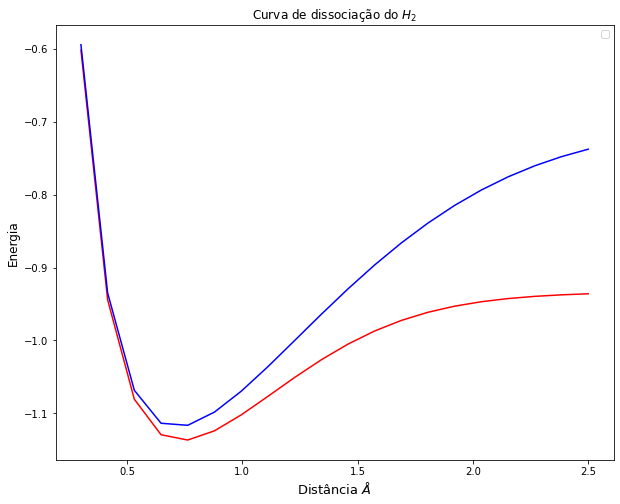

In [446]:
n=20
distances = np.linspace(0.3, 2.5, n)
exact_energy = []
energies = []

for i, distance in enumerate(distances):
    
    mol_gates, mol_co = get_molecule(distance)
    co = [c.real for c in mol_co]
    H = sum([gate*co for gate,co in zip(get_H_k(mol_gates)[0], mol_co)])
    exact_energy.append(min(scipy.linalg.eig(H.get())[0]))
    
    initial_values = np.random.uniform(-np.pi, np.pi, 4)
    minimum = minimize(expectation_energy, initial_values, method='SLSQP',options={'xtol': 1e-5, 'ftol': 1e-5}, args=(co))
    energies.append(minimum.fun)
    
fig, ax = plt.subplots(1, 1, figsize=(10,8))
ax.plot(distances, exact_energy, color='red')
ax.plot(distances, energies, color='blue')
ax.set_xlabel('Distância $\AA$', fontsize=13)
ax.set_ylabel('Energia', fontsize=12)
ax.set_title('Curva de dissociação do $H_2$', fontsize=12)
ax.legend()
plt.show()